In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import datasets 
from tensorflow.keras import layers 
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses, optimizers, metrics
from tensorflow.keras import callbacks 
from tensorflow.keras.models import Sequential

import activationsf

In [2]:
# Check tf version
!python -c 'import tensorflow as tf; print(tf.__version__)' 

2020-05-27 10:52:05.196684: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2.3.0-dev20200521


In [2]:
# Load CIFAR10 
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

In [3]:
# Wrap using tf.data for better performane
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [5]:
# Set Early Stopping
es = callbacks.EarlyStopping(
        monitor='val_accuracy',
        # "no longer improving" being defined as "no increase greater or equal than 1e-2"
        min_delta=5e-3,
        patience=5,
        mode='max', 
        verbose=1)

In [6]:
# plot diagnostic learning curves
def summarize_diagnostics(history, fine_tuning=False):
	
	if fine_tuning :
		color_train = 'green'
		color_validation = 'red'
	else :
		color_train = 'blue'
		color_validation = 'orange'

	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color=color_train, label='train')
	plt.plot(history.history['val_loss'], color=color_validation, label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color=color_train, label='train')
	plt.plot(history.history['val_accuracy'], color=color_validation, label='test')
	plt.show()
	plt.close()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

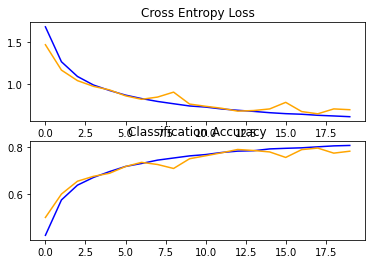


 Model Evaluation 

157/157 [==============================] - 2s 10ms/step - loss: 0.7006 - accuracy: 0.7840

 Save the Model 

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_custom_model/elu_cnn/assets


In [8]:
elu_cnn = Sequential([
  
  # VGG inspired model: 
  layers.Conv2D(32, 3, padding='same', activation='elu', kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='elu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation='elu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='elu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed=42),

  #layers.Conv2D(128, 3, padding='same', activation='elu', kernel_initializer='he_uniform'),
  #layers.BatchNormalization(),
  #layers.Conv2D(128, 3, padding='same', activation='elu', kernel_initializer='he_uniform'),
  #layers.BatchNormalization(),
  #layers.MaxPooling2D(pool_size=(2,2)),
  #layers.Dropout(0.4, seed=42),

  tf.keras.layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.0012)),
  layers.Dropout(0.4, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012))
])

elu_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
  
elu_cnn.summary()

print('\nTraining \n')
history_elu = elu_cnn.fit(x = x_train, y = y_train, batch_size = 64, epochs=20, validation_data=(x_test, y_test), callbacks=[es])

summarize_diagnostics(history_elu)

print('\nModel Evaluation \n')
elu_cnn.evaluate(x = x_test, y = y_test, batch_size=64)

print('\nSave the Model \n')
elu_cnn.save('saved_custom_model/elu_cnn') 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
kwta_1 (Kwta)                (None, 32, 32, 32)        1         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
kwta_2 (Kwta)                (None, 32, 32, 32)        1         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

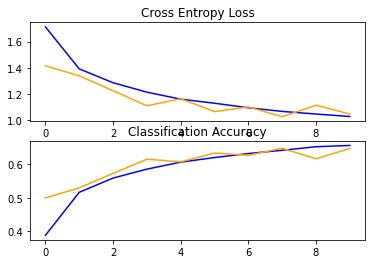


 Fine tune learned weights until ratio is equal to 0.15 


 Fine tuning: current ratio 0.29 

Epoch 1/30
1563/1563 [==============================] - 32s 21ms/step - loss: 1.0148 - accuracy: 0.6632 - val_loss: 1.1025 - val_accuracy: 0.6181
Epoch 2/30
1563/1563 [==============================] - 32s 21ms/step - loss: 1.0020 - accuracy: 0.6687 - val_loss: 0.9763 - val_accuracy: 0.6724

 Fine tuning: current ratio 0.28 

Epoch 3/30
1563/1563 [==============================] - 32s 21ms/step - loss: 0.9869 - accuracy: 0.6714 - val_loss: 1.1059 - val_accuracy: 0.6188
Epoch 4/30
1563/1563 [==============================] - 32s 21ms/step - loss: 0.9761 - accuracy: 0.6785 - val_loss: 0.9713 - val_accuracy: 0.6748

 Fine tuning: current ratio 0.27 

Epoch 5/30
1563/1563 [==============================] - 33s 21ms/step - loss: 0.9679 - accuracy: 0.6794 - val_loss: 1.0065 - val_accuracy: 0.6611
Epoch 6/30
1563/1563 [==============================] - 33s 21ms/step - loss: 0.9617 - accuracy: 0.6819

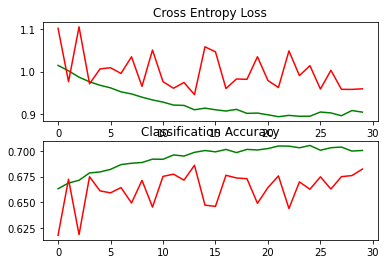


 Model Evaluation 

313/313 [==============================] - 4s 13ms/step - loss: 0.9595 - accuracy: 0.6822

 Save the Model 

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_custom_model/kwta_cnn/assets


In [7]:
kwta_cnn = Sequential([
  
  # Same architecture, use KWTA instead of ELU
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  activationsf.Kwta(ratio=0.30, conv=True, name='kwta_1'),
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kwta(ratio=0.30, conv=True, name='kwta_2'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kwta(ratio=0.30, conv=True, name='kwta_3'),
  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kwta(ratio=0.30, conv=True, name='kwta_4'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.30, seed=42),

  #layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  #layers.BatchNormalization(),
  #activationsf.Kwta(ratio=0.30, conv=True, name='kwta_5'),
  #layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  #layers.BatchNormalization(),
  #activationsf.Kwta(ratio=0.30, conv=True, name='kwta_6'),
  #layers.MaxPooling2D(pool_size=(2,2)),
  #layers.Dropout(0.4, seed=42),

  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  activationsf.Kwta(ratio=0.30, name='kwta_5'),
  layers.Dropout(0.4, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012))
  
])

kwta_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


kwta_cnn.summary()

print('\n Train with ratio 0.30 until convergence \n')
history_kwta_es = kwta_cnn.fit(train.shuffle(500).batch(32), epochs = 10, validation_data=(x_test, y_test), callbacks=[es])
summarize_diagnostics(history_kwta_es)

print('\n Fine tune learned weights until ratio is equal to 0.15 \n')
history_kwta_ft = kwta_cnn.fit(train.shuffle(500).batch(32), epochs = 30, validation_data=(x_test, y_test), callbacks=[activationsf.incremental_learning_withDecreasing_ratio(num_layers=5)])
summarize_diagnostics(history_kwta_ft, fine_tuning=True)

print('\n Model Evaluation \n')
kwta_cnn.evaluate(x = x_test, y = y_test, batch_size=32)

print('\n Save the Model \n')
kwta_cnn.save('saved_custom_model/kwta_cnn') 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
kaf_1 (Kaf)                  (None, 32, 32, 32)        660       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
kaf_2 (Kaf)                  (None, 32, 32, 32)        660       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)       

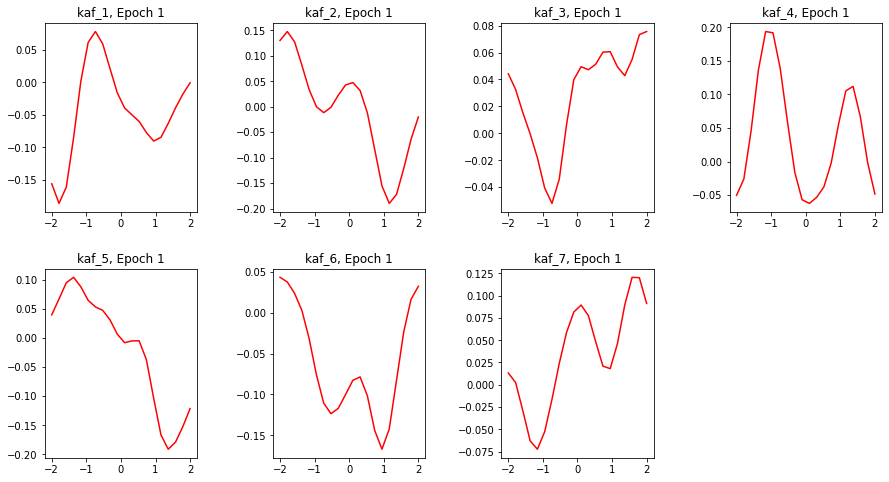

Epoch 1/20
  26/1563 [..............................] - ETA: 5:35 - loss: 2.4797 - accuracy: 0.0974

KeyboardInterrupt: 

In [15]:
# Might speed up training casting computation to tf.float16.
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')

kaf_cnn = Sequential([
  
  # Using KAFs instead
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_1'),
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_2'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_3'),
  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=16, name='kaf_4'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed=42),

  #layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  #layers.BatchNormalization(),
  #activationsf.Kaf(conv=True, D=16, name='kaf_5'),
  #layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  #layers.BatchNormalization(),
  #activationsf.Kaf(conv=True, D=16, name='kaf_6'),
  #layers.MaxPooling2D(pool_size=(2,2)),
  #layers.Dropout(0.4, seed=42),

  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  activationsf.Kaf(D=16, name='kaf_5'),
  layers.Dropout(0.4, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012), dtype=tf.float32)
])

kaf_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

kaf_cnn.summary()

# Train until convergence
history_kaf = kaf_cnn.fit(train.shuffle(1000).batch(32), epochs = 20, validation_data=(x_test, y_test), callbacks=[activationsf.plot_kafs_epoch_wise(num_layers=5)])
summarize_diagnostics(history_kaf)

kaf_cnn.evaluate(x = x_test, y = y_test, batch_size=32)

# Save kaf_cnn
kaf_cnn.save('saved_custom_model/kaf_cnn')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
kaf_1 (Kaf)                  (None, 32, 32, 32)        660       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
kaf_2 (Kaf)                  (None, 32, 32, 32)        660       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)       

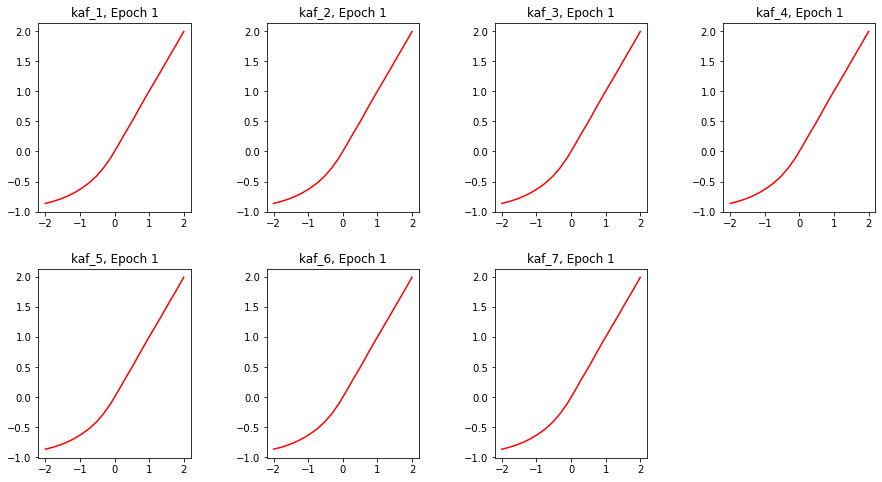

Epoch 1/20
  12/1563 [..............................] - ETA: 5:26 - loss: 509.0585 - accuracy: 0.1562

KeyboardInterrupt: 

In [17]:
elukaf_cnn = Sequential([
  
  # Using KAFs ELU-Ridge initialized
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, ridge='elu', name='kaf_1'),
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, ridge='elu', name='kaf_2'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2, seed=42),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, ridge='elu', name='kaf_3'),
  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, ridge='elu', name='kaf_4'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3, seed=42),

  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, ridge='elu', name='kaf_5'),
  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, ridge='elu', name='kaf_6'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.4, seed=42),

  layers.GlobalAveragePooling2D(),
  layers.Dense(256, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  activationsf.Kaf(D=20, ridge='elu', name='kaf_7'),
  layers.Dropout(0.5, seed=42),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012))
])

elukaf_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

elukaf_cnn.summary()

# Train until convergence
history_kaf = elukaf_cnn.fit(train.shuffle(500).batch(32), epochs = 20, validation_data=(x_test, y_test), callbacks=[es, activationsf.plot_kafs_epoch_wise(num_layers=7)])
summarize_diagnostics(history_kaf)

elukaf_cnn.evaluate(x = x_test, y = y_test, batch_size=32)

# Save elukaf_cnn
elukaf_cnn.save('saved_custom_model/elukaf_cnn')